In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# load dataset
mkt = pd.read_csv('marketing_AB.csv')
mkt.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


## Introduction
The Marketing dataset I used here is obtained from Kaggle (https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing/). 

Here are the list of variables:
- User ID: represents a member of the two testing groups
- Test Group: "ad" test group for people that saw the advertisement and "psa" test group for people that only saw the public service announcement
- Converted: "true" if the member bought the product and "false" if not
- Total Ads: # of ads seen by the member
- Most Ads Day: day that the member saw the largest # of ads
- Most Ads Hour: hour of the day that the member saw the largest # of ads

The first part of this project is data cleaning. To do this, I dropped rows with NA values and delted the indexing column that came with the dataset.

In [9]:
# data cleanup
print('Unique values of the "test group" column:', mkt['test group'].unique())

del mkt['Unnamed: 0']

mkt.shape

Unique values of the "test group" column: ['ad' 'psa']


(588101, 6)

In [10]:
# data cleanup

mkt = mkt.dropna()
mkt.shape

(588101, 6)

Next, I visualized different aspects of the dataset. The first visualization is a bar graph that plots the amount of ad occurrences by day of the week and testing group. The bar graph makes it obvious that there were a lot more ad occurrences for the "ad" test group than the "psa" group. The bar graph also shows that the ad occurrences don't vary much by the day of the week. Regardless, the lowest ad occurrences for the "ad" group happened on Tuesday, while the highest occurred on Friday.

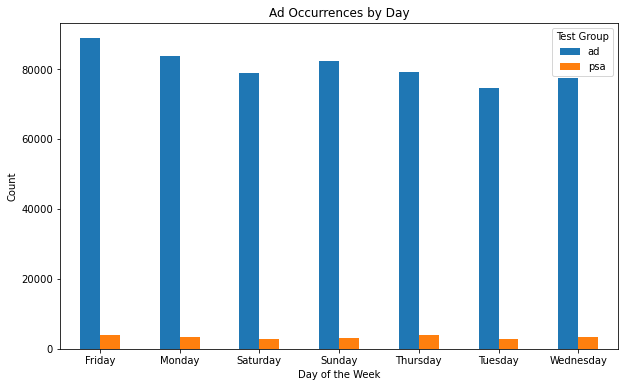

In [23]:
## visualize ad occurrences by day of the week with a bar graph

# count the occurrences
day_count = mkt.groupby(['most ads day', 'test group']).size().unstack(fill_value=0)

# create bar graph
day_count.plot(kind='bar', stacked=False, figsize=(10,6))
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Ad Occurrences by Day')
plt.xticks(rotation=360)
plt.legend(title='Test Group')
plt.show()

The second visualization is another bar graph but this time it is comparing the conversion rate by the test group. It is apparent that the "ad" group converted more members into product purchases than the "psa" group.

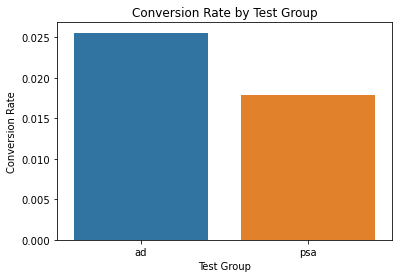

In [25]:
# visualize conversion rate by test group bar graph
conversion_by_group = mkt.groupby('test group')['converted'].mean().reset_index()
sns.barplot(x='test group', y='converted', data=conversion_by_group)
plt.xlabel('Test Group')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Test Group')
plt.show()


The last visualization that I did involved a histogram of the total number of ads seen. It results in a right-skewed histogram.

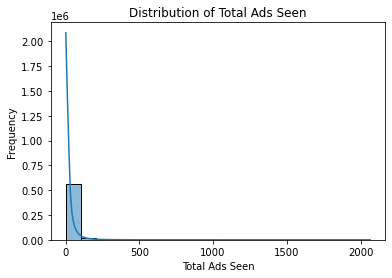

In [26]:
# histogram of total ads seen
sns.histplot(mkt['total ads'], bins=20, kde=True)
plt.xlabel('Total Ads Seen')
plt.ylabel('Frequency')
plt.title('Distribution of Total Ads Seen')
plt.show()

## A/B Testing
I conducted A/B testing with both a chi-squared test and a t-test. As you can see below, the p-value ended up far below 0.05 for both tests. This indicates that there is a significant difference in the conversion rate between the two testing groups.

In [27]:
## A/B testing with chi squared test
from scipy.stats import chi2_contingency

conversion_counts = mkt.groupby('test group')['converted'].value_counts().unstack(fill_value=0)

chi2, p, dof, expected = chi2_contingency(conversion_counts)

print(f"Chi-Squared Statistic: {chi2}")
print(f"P-value: {p}")

# null hypothesis is that there's no difference in conversion rate between the two test groups
# if p < 0.05, then reject null >> significant difference in conversion rates

# here we can see that p <<< 0.05 so there is a significant difference in conversion rate

Chi-Squared Statistic: 54.005823883685245
P-value: 1.9989623063390075e-13


In [28]:
## A/B testing with t-test
from scipy.stats import ttest_ind

group_ad = mkt[mkt['test group'] == 'ad']['converted']
group_psa = mkt[mkt['test group'] == 'psa']['converted']

t_statistic, p_value = ttest_ind(group_ad, group_psa, equal_var=False)

print(f"T-Statistic: {t_statistic}")
print(f"P-value: {p_value}")

# here we can see that p <<< 0.05 so there is a significant difference in conversion rate

T-Statistic: 8.657162314551679
P-value: 5.107607598758945e-18


## Logistic Regression Model
Lastly, I split the dataset and trained them to form the logistic regression model. The first regression model involved multiple predictive variables such as test group, total ads, most ads day, and most ads hour. It predicted the amount of conversions. 

In [39]:
## logistic regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# encode categorical variables
label_encoder = LabelEncoder()
mkt['test group'] = label_encoder.fit_transform(mkt['test group'])
mkt['most ads day'] = label_encoder.fit_transform(mkt['most ads day'])

# define variables
X = mkt[['test group', 'total ads', 'most ads day', 'most ads hour']]
y = mkt['converted']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print('\nClassification Report:\n\n', classification_report(y_test, y_pred))

# coefficients
coefficients = model.coef_
intercept = model.intercept_
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

Accuracy: 0.9734061094532439

Classification Report:

               precision    recall  f1-score   support

       False       0.97      1.00      0.99    114632
        True       0.19      0.01      0.03      2989

    accuracy                           0.97    117621
   macro avg       0.58      0.51      0.51    117621
weighted avg       0.95      0.97      0.96    117621

Coefficients: [[-0.39122249  0.01023996  0.01608931  0.03250855]]
Intercept: [-4.57469403]


The second regression model had just one predictive variable, which is the testing group.

In [36]:
## logistic regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# encode categorical variables
label_encoder = LabelEncoder()
mkt['test group'] = label_encoder.fit_transform(mkt['test group'])

# define variables
X = mkt[['test group']]
y = mkt['converted']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print('\nClassification Report:\n\n', classification_report(y_test, y_pred))

# coefficients
coefficients = model.coef_
intercept = model.intercept_
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

Accuracy: 0.9745878712134738


C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Amulya Cherian\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:

               precision    recall  f1-score   support

       False       0.97      1.00      0.99    114632
        True       0.00      0.00      0.00      2989

    accuracy                           0.97    117621
   macro avg       0.49      0.50      0.49    117621
weighted avg       0.95      0.97      0.96    117621

Coefficients: [[-0.36969362]]
Intercept: [-3.64303019]


Both regression models don't vary much in accuracy so the number of predictive variables utilized does not have much of an effect on being able to predict if conversion occurs or not. 